In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

In [2]:
from Advanced_Interference_Channel import Advanced_Interference_Channel

In [3]:
class SBRNN(nn.Module):
    def __init__(self, input_shape, num_lstm1, num_lstm2, num_dense1, num_dense2, training=True):
        super(SBRNN,self).__init__()
        self.inp_shape = input_shape
        self.outp_shape = (input_shape[0], input_shape[1], num_dense2)
        
        self.num_lstm1 = num_lstm1
        self.num_lstm2 = num_lstm2
        self.num_dense1 = num_dense1
        self.num_dense2 = num_dense2
        self.training = training
        self.init_hidden()
        self.last_window = False
        
        if self.training==False:
            #counter for correct averaging
            self.init_counter()
            #memory to store results of past predictions
            self.memory = np.zeros((self.inp_shape[0],self.inp_shape[1],num_dense2))
        
        
        #defining the layers
        #input has shape (sequ_len, batch, num_features)
        self.lstm1 = nn.LSTM(self.inp_shape[2], self.num_lstm1 ,num_layers=1, bidirectional=True)
        self.concat1 = nn.Linear(self.num_lstm1*2, self.num_lstm1)       #*2 bidirectional
        self.lstm2 = nn.LSTM(self.num_lstm1, self.num_lstm2, num_layers=1, bidirectional=True)
        self.concat2 = nn.Linear(self.num_lstm2*2, self.num_lstm2)       #*2 bidirectional
        self.dense1 = nn.Linear(self.num_lstm2, self.num_dense1)
        self.dense2 = nn.Linear(self.num_dense1, self.num_dense2)    
    
    def init_hidden(self, hidden1=None, hidden2=None):
        if hidden1==None and hidden2==None:
            #tuple of 2 tensors because LSTMs have a second state, which must be initialized
            #2 in 1st dimension, because of bidirectional LSTMs
            #                                batch_size            
            self.hidden1 = (torch.randn(2, self.inp_shape[1], self.num_lstm1), 
                            torch.randn(2, self.inp_shape[1], self.num_lstm1))
        
            self.hidden2 = (torch.randn(2, self.inp_shape[1], self.num_lstm2), 
                            torch.randn(2, self.inp_shape[1], self.num_lstm2))
        #if the hidden state is passed between different windows
        else:
            self.hidden1 = hidden1
            self.hidden2 = hidden2
        
    def init_counter(self):
        self.counter = 1
        self.last_window = False
        
    def forward(self,x):
        x, self.hidden1 = self.lstm1(x, self.hidden1)
        x = F.relu(self.concat1(x))
        x, self.hidden2 = self.lstm2(x, self.hidden2)
        x = F.relu(self.concat2(x))
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        
        if self.training == True:
            return x
        else:
            x = F.softmax(x, dim=2)
            x = self._average_outputs(x)
        return x
    
    #to be only used without training, gradient is lost
    def _average_outputs(self,x):
        self.memory += x.detach().numpy()

        if self.last_window == False:
            x = torch.from_numpy(self.memory[0,:,:])/float(self.counter)
            #reshaping x to always have the same dimensions
            x = x.reshape(-1,self.outp_shape[1], self.outp_shape[2])
            #shift one element to the left and fill with zeros
            self.memory = np.roll(self.memory, -1, axis=0)
            self.memory[-1,:,:] = np.zeros((self.inp_shape[1],num_dense2))
            
            #to correctly normalize the outputs in the first window
            if self.counter < self.inp_shape[0]:
                self.counter += 1
            
            
        elif self.last_window == True:
            for i in range(len(self.memory[:,0,0])):
                self.memory[i,:,:] = self.memory[i,:,:]/self.counter

                
                if self.counter>1:
                    self.counter -= 1
            x = torch.from_numpy(self.memory)
        
        return x

In [4]:
#to assign the targets to class numbers
def target_correction(y_pred_batch):
    shape = y_pred_batch.shape
    y_pred_batch = np.argmax(y_pred_batch, axis=2)    
    y_pred_batch = y_pred_batch.reshape((shape[0],shape[1], 1))
    y_pred_batch[y_pred_batch==0] = -1
    return y_pred_batch

In [5]:
class My_Viterbi:
    def __init__(self, channel):
        self.states = np.array([1,-1])
        self.channel = channel
    
    def equilize(self, input_array):
        T = input_array.shape[0]
        
        #Metrics
        M = np.zeros((2,T), dtype="float")
        
        M[:,0] = np.array([0,1]) if input_array[0] > 0 else np.array([1,0])
        
        
        for t in range(1,T):
            M[:,t] = self.__new_metric(input_array[t],M[:,t-1])
            
        sequence = np.argmin(M, axis =0)

        sequence[sequence==1] = -1.
        sequence[sequence==0] = 1.
        
        return sequence
        
        
        
        
    def __new_metric(self, y_i, M):
        coeffs = np.array(self.channel.memory_coefficients)
        x = np.matmul(coeffs, [[1,-1, 1,-1],
                               [1, 1,-1,-1]])
        
        metric_array = np.square(np.abs(x-y_i))
        
        a = np.min(np.array([M[0]+metric_array[0], M[1]+metric_array[2]]))
        b = np.min(np.array([M[0]+metric_array[1],M[1]+metric_array[3]]))
        
        
        
        return np.array([a,b])

In [6]:
class My_Viterbi_Hamming:
    def __init__(self, channel):
        self.states = np.array([1,-1])
        self.channel = channel
    
    def equilize(self, input_array):
        
        # making the 1-bit-quantization
        input_array[input_array>0] = 1
        input_array[input_array<0] = 0
        
        T = input_array.shape[0]
        
        #Metrics
        M = np.zeros((2,T), dtype="float")
        
        M[:,0] = np.array([0,1]) if input_array[0] == 1 else np.array([1,0])
        
        
        for t in range(1,T):
            M[:,t] = self.__new_metric(input_array[t],M[:,t-1])
            
        sequence = np.argmin(M, axis =0)

        sequence[sequence==1] = -1.
        sequence[sequence==0] = 1.
        
        return sequence
        
        
        
        
    def __new_metric(self, y_i, M):
        metric_array = np.abs(np.array([1,0])-y_i)
        
        a = np.min(np.array([M[0]+metric_array[0], M[1]+metric_array[0]]))
        b = np.min(np.array([M[0]+metric_array[1],M[1]+metric_array[1]]))
        
        
        
        return np.array([a,b])

In [7]:
#defining the test parameters
load_path = "pytorch_model.pt"
T_s = 1
T_r = 1
T_r_net = 0.2
test_sequ_length = 100000
batch_size = 1

window_size = 50
num_lstm1 = 150
num_lstm2 = 110
num_dense1 = 80
num_dense2 = 2
num_epochs = 2

input_shape = (window_size, batch_size, int(T_s/T_r_net))

channel = Advanced_Interference_Channel()

sbrnn = SBRNN(input_shape, num_lstm1, num_lstm2, num_dense1, num_dense2, training=False)
sbrnn.load_state_dict(torch.load(load_path))
sbrnn.eval()
vit_ham = My_Viterbi_Hamming(channel)
vit_soft = My_Viterbi(channel)

#to save SNR, bit error rates of SBRNN, Viterbi and Viterbi with Hamming distance
biterror_snr_list = [[],[],[],[],[]]

for snr_db in range(0,22):
    #calculating the noise variance
    var_n = 1/float(10**(snr_db/10.0))
    channel.noise_variance = var_n
    
    
    transmit_seq = np.random.choice([-1,1],test_sequ_length)
    
    
    ############################## SBRNN Detection Part  ##################################
    
    #first transmission with T_s = 1 and Nyquist-signaling 
    channel.transmit(transmit_seq,T_s,1)
    
    received_seq = channel.receive(T_r_net)
    #remove the unnecessary components at the end and at the beginning of the sequence
    #             10 because of periods of sinc
    #           2 beacause of convolving 2 times with sinc
    #                          #to get the correct sample point in the middle of the vector
    start = int(2*10*T_s/T_r_net - int(0.5/T_r_net))
    stop  = int(start+ test_sequ_length*int(T_s/T_r_net))
    
    received_seq = received_seq[start:stop]
    # 1-bit quantization
    received_seq[received_seq<0] = 0
    received_seq[received_seq>0] = 1
    
    #reshaping and type conversion for PyTorch
    received_seq = received_seq.reshape(test_sequ_length, batch_size, int(T_s/T_r_net))
    transmit_seq = transmit_seq.reshape(-1,batch_size,1)
    received_seq = received_seq.astype("float32")
    
    #creating an empty array
    sbrnn_prediction = np.zeros((test_sequ_length, batch_size, num_dense2))
    
    num_windows = test_sequ_length - window_size + 1
    #iterating over all windows, giving special treatment to the last window
    for i in range(num_windows-1):
        #prediction for 1 element per window
        sbrnn_prediction[i,:,:] = sbrnn(torch.from_numpy(received_seq[i:i+window_size,:,:]))
        
        hidden1_temp = (sbrnn.hidden1[0].detach(), sbrnn.hidden1[1].detach())
        hidden2_temp = (sbrnn.hidden2[0].detach(), sbrnn.hidden2[1].detach())
        sbrnn.init_hidden(hidden1_temp, hidden2_temp)
        
    #last window results in window_size predictions elements
    sbrnn.last_window = True
    sbrnn_prediction[-window_size:,:,:] = sbrnn(torch.from_numpy(received_seq[-window_size:,:,:]))
    #restart the counter and init the hidden state
    sbrnn.init_counter()
    sbrnn.init_hidden()
    
    #to transform the 0s and 1s to -1s and 1s
    sbrnn_prediction = target_correction(sbrnn_prediction)
        
    ##############################  Viterbi Detection Part  ##############################
    
    #transmitting the same sequence again
    channel.transmit(transmit_seq,T_s,1)
    
    
    
    #receiving without oversampling
    received_seq = channel.receive(T_r)
    
    #remove the unnecessary components at the end and at the beginning of the sequence
    start = int(2*10*T_s/T_r - int(0.5/T_r))
    stop  = int(start+ test_sequ_length*int(T_s/T_r))
    received_seq = received_seq[start:stop]
    
    
    received_seq = received_seq.reshape(-1,int(T_s/T_r))
    
    #prediction of both Viterbi equilizers
    viterbi_prediction = vit_soft.equilize(received_seq)
    vertibi_hamming_prediction = vit_ham.equilize(received_seq)
    
    ############################  Calculating Bit Error Rates  ##############################
    
    num_bit_errors_net = np.count_nonzero(sbrnn_prediction-transmit_seq)
    num_bit_errors_vit = np.count_nonzero(viterbi_prediction-transmit_seq.flatten())
    num_bit_errors_vit_ham = np.count_nonzero(vertibi_hamming_prediction-transmit_seq.flatten())
    
    bit_error_rate_net = num_bit_errors_net/float(test_sequ_length)
    bit_error_rate_vit = num_bit_errors_vit/float(test_sequ_length)
    bit_error_rate_vit_ham = num_bit_errors_vit_ham/float(test_sequ_length)
    
    biterror_snr_list[0].append(snr_db)
    biterror_snr_list[1].append(bit_error_rate_net)
    biterror_snr_list[2].append(bit_error_rate_vit)
    biterror_snr_list[3].append(bit_error_rate_vit_ham)
    print("Testing SNR ",snr_db, " done" )
    
    
df = pd.DataFrame({"SNR": biterror_snr_list[0],
                   "Neuronales Netz": biterror_snr_list[1],
                   "Viterbi, Softinformationen":biterror_snr_list[2],
                   "Viterbi, Hamming Distanz": biterror_snr_list[3]})
df.to_csv("Testdaten.csv")
    


Testing SNR  0  done
Testing SNR  1  done
Testing SNR  2  done
Testing SNR  3  done
Testing SNR  4  done
Testing SNR  5  done
Testing SNR  6  done
Testing SNR  7  done
Testing SNR  8  done
Testing SNR  9  done
Testing SNR  10  done
Testing SNR  11  done
Testing SNR  12  done
Testing SNR  13  done
Testing SNR  14  done
Testing SNR  15  done
Testing SNR  16  done
Testing SNR  17  done
Testing SNR  18  done
Testing SNR  19  done
Testing SNR  20  done
Testing SNR  21  done


In [8]:
import matplotlib.pyplot as plt

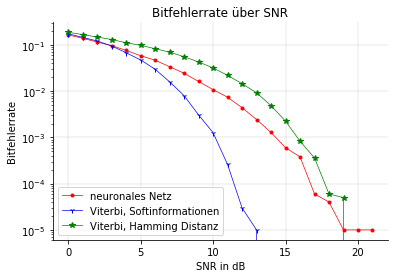

In [9]:
fig, ax = plt.subplots()
ax.set_title("Bitfehlerrate über SNR")
ax.set_ylabel("Bitfehlerrate")
ax.set_xlabel("SNR in dB")
ax.set_yscale("log")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.7)
ax.plot(np.array(biterror_snr_list[0]), np.array(biterror_snr_list[1]), label="neuronales Netz", marker='.', 
        linewidth=0.7, color='red')
ax.plot(np.array(biterror_snr_list[0]), np.array(biterror_snr_list[2]),
        label="Viterbi, Softinformationen", marker='1', linewidth=0.7, color='blue')
ax.plot(np.array(biterror_snr_list[0]), np.array(biterror_snr_list[3]), label="Viterbi, Hamming Distanz",
        marker='*', linewidth=0.7, color='green')


plt.legend()
plt.savefig("PyTorch_model.pdf")
plt.show()